# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **economic activity or measures** (see below) for the region of **Helsinki, Uusimaa, Finland**, or **Finland** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **Helsinki, Uusimaa, Finland** to Ann Arbor, USA. In that case at least one source file must be about **Helsinki, Uusimaa, Finland**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **Helsinki, Uusimaa, Finland** and **economic activity or measures**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **economic activity or measures**?  For this category you might look at the inputs or outputs to the given economy, or major changes in the economy compared to other regions.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

In [1]:
################################################################
# Code for Assigment 4 in the 2nd course of Applied Data Science
# specialization of University of Michigan at Courseta.
# Resulting graph/poster sheds light on parking tickets and
# warnings in Helsinki, Finland

# Data sources
# https://www.avoindata.fi/data/fi/dataset/pysakointivirheet-helsingissa
# http://www.palomaki.info/apps/pnro/
################################################################

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import display
import mplleaflet
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline; border:0px"')          
    display_html(html_str,raw=True)

## Parking ticket information

In [2]:
# Read in data frame. This takes a while as the file is quite big!
df_safe = pd.read_excel('helsinki_parking_tickets.xlsx')

In [3]:
# Copy to working data frame
df = df_safe.copy()

# Translate column names to English
df.columns = ['Month', 'Year', 'Address', 'Type', 'Reason', 'Responsible', 'x', 'y', 'ZIP_Code', 'ZIP_Area', 'Area', 'Municipality', 'Mun_no']

# Leave only observations in Helsinki, reduces obs 398831 -> 310634
df = df[df['Municipality'] == 'Helsinki']

# Leave only interesting columns
columns_to_keep = ['Month','Year','Type', 'Reason', 'Area', 'ZIP_Code']
df = df[columns_to_keep]

# Translate month values into English
month_mapping = {'Tammikuu':'January', 'Helmikuu':'February', 'Maaliskuu':'March'
                 ,'Huhtikuu':'April', 'Toukokuu':'May', 'Kesäkuu':'July'
                 ,'Heinäkuu':'July', 'Elokuu':'August', 'Syyskuu':'September'
                 ,'Lokakuu':'October', 'Marraskuu':'November', 'Joulukuu':'December'}
df['Month'] = df['Month'].map(month_mapping)

# Translate ticket types into English
type_mapping = {'Pysäköintivirhemaksu':'Ticket', 'Huomautus':'Warning'}
df['Type'] = df['Type'].map(type_mapping)

# Convert zip codes to ints
df['ZIP_Code'] = df['ZIP_Code'].astype('int64')

# Map zip codes to tiers. This might need expert adjustment...
df['Tier'] = pd.cut(df['ZIP_Code']
                    ,[0, 100, 200, 400, 600, np.inf]
                    ,labels = [1,2,3,4,5]
                    ,right = True)

# Convert zip codes to strings for later use
df['ZIP_Code'] = '00' + df['ZIP_Code'].astype(str)

df.reset_index(inplace = True, drop = True)

In [4]:
# Extract incident reason from strings
# This is a pretty long loop, progress is printed out in the console
codes_list = [0] * len(df)
codes_length = [0] * len(df)
reason_codes = []
reasons_counts = []
reason_strings = []

regex1 = re.compile(r'\d+')
counter = 0
for _, row in df.iterrows():

    if type(row['Reason']) == float:        
        str1 = ['9999999 Unknown reason']
    else:
        # Reasons are separated by ;
        str1 = row['Reason'].split(';')        
        str1 = list(map(str.strip, str1))
        
    # Loop over reasons and extract codes/strings
    crt_codes = []
    for string in str1:   
        crt_code = string.split(' ')[0]
        crt_codes.append(crt_code)
        crt_str = re.sub(r"^([^\d]*)\d*", '', string).strip()        
        # Append to list of unique codes and strings if found for first time
        if crt_code not in reason_codes:
            reason_codes.append(crt_code)
            reason_strings.append(crt_str)
            reasons_counts.append(1)
        else:
            index = reason_codes.index(crt_code)
            reasons_counts[index] += 1

    # Save reason codes for each observations       
    codes_list[counter] = crt_codes
    codes_length[counter] = len(crt_codes)
    
    counter += 1
    
    if counter == 50000:
        print('50k')
    elif counter == 100000:
        print('100k')
    elif counter == 200000:        
        print('200k')    
    elif counter == 250000:        
        print('250k')            
    elif counter == 300000:        
        print('300k')      
    elif counter == 350000:        
        print('350k')              
    
# Append code list to DataFrame
df['reasons_list'] = codes_list
df['reasons_len'] = codes_length
del df['Reason']

50k
100k
200k
250k
300k
350k


In [5]:
# Get the most common reason for parking incident
reasons_counts, reason_strings = (list(t) for t in zip(*sorted(zip(reasons_counts, reason_strings),reverse=True)))
print(reasons_counts[0:3], reason_strings[0:3])

[54039, 50257, 43489] ['Pysäköinti kielletty liikennemerkin noudattamatta jättäminen', 'pysäköinti ilman p-tunnusta/p-laitetta/p-lippua', 'Pysäköintikieltoalue liikennemerkin noudattamatta jättäminen']


In [6]:
print(len(reason_codes))
df.tail(5)

141


,Month,Year,Type,Area,ZIP_Code,Tier,reasons_list,reasons_len
393597,August,2014,Ticket,Malmi,00700,5,[0905],1
393598,November,2014,Ticket,Malmi,00700,5,[0905],1
393599,July,2014,Ticket,Malmi,00700,5,[2301],1
393600,July,2014,Ticket,Malmi,00700,5,[2301],1
393601,March,2014,Ticket,Malmi,00700,5,[0905],1


In [7]:
# Expert adjustments for tiers
hh = df[['ZIP_Code', 'Area', 'Tier']].copy()
hh.drop_duplicates(inplace = True)
hh.sort_values('ZIP_Code', inplace=True)
hh.reset_index(inplace = True, drop = True)
hh.loc[hh['Tier'] == 5,].head(5)

,ZIP_Code,Area,Tier
44,00610,Käpylä,5
45,00620,Metsälä-Etelä-Oulunk,5
46,00630,Maunula-Suursuo,5
47,00640,Oulunkylä-Patola,5
48,00650,Veräjämäki,5


In [8]:
# Expert adjustments for tiers, continued
df.loc[df['Area'] == 'Lauttasaari','Tier'] = 3
df.loc[df['Area'] == 'Sörnäinen','Tier'] = 3
df.loc[df['Area'] == 'Etu-Vallila','Tier'] = 3
df.loc[df['Area'] == 'Itä-Pasila','Tier'] = 3
df.loc[df['Area'] == 'Kallio','Tier'] = 3
df.loc[df['Area'] == 'Kalasatama','Tier'] = 3
df.loc[df['Area'] == 'Vallila','Tier'] = 3

df.loc[df['Area'] == 'Pikku Huopalahti','Tier'] = 4
df.loc[df['Area'] == 'Ruskeasuo','Tier'] = 4
df.loc[df['Area'] == 'Kivihaka','Tier'] = 4
df.loc[df['Area'] == 'Etelä-Haaga','Tier'] = 4
df.loc[df['Area'] == 'Munkkiniemi','Tier'] = 4
df.loc[df['Area'] == 'Kuusisaari-Lehtisaar','Tier'] = 4
df.loc[df['Area'] == 'Munkkivuori-Niemenmä','Tier'] = 4
df.loc[df['Area'] == 'Pajamäki','Tier'] = 4
df.loc[df['Area'] == 'Reimarla','Tier'] = 4
df.loc[df['Area'] == 'Pitäjänmäen teollisu','Tier'] = 4
df.loc[df['Area'] == 'Konala','Tier'] = 4
df.loc[df['Area'] == 'Pohjois-Haaga','Tier'] = 4
df.loc[df['Area'] == 'Käpylä','Tier'] = 4
df.loc[df['Area'] == 'Käpylä','Tier'] = 4
df.loc[df['Area'] == 'Käpylä','Tier'] = 4
df.loc[df['Area'] == 'Käpylä','Tier'] = 4
df.loc[df['Area'] == 'Käpylä','Tier'] = 4
df.loc[df['Area'] == 'Käpylä','Tier'] = 4
df.loc[df['Area'] == 'Metsälä-Etelä-Oulunk','Tier'] = 4
df.loc[df['Area'] == 'Maunula-Suursuo','Tier'] = 4
df.loc[df['Area'] == 'Oulunkylä-Patola','Tier'] = 4
df.loc[df['Area'] == 'Viikki','Tier'] = 4
df.loc[df['Area'] == 'Veräjämäki','Tier'] = 4
df.loc[df['Area'] == 'Pihlajamäki','Tier'] = 4
df.loc[df['Area'] == 'Herttoniemi','Tier'] = 4
df.loc[df['Area'] == 'Pihlajamäki','Tier'] = 4
df.loc[df['Area'] == 'Länsi-Herttoniemi','Tier'] = 4

df.loc[df['Area'] == 'Malminkartano','Tier'] = 5
df.loc[df['Area'] == 'Kannelmäki','Tier'] = 5
df.loc[df['Area'] == 'Maununneva','Tier'] = 5
df.loc[df['Area'] == 'Konala','Tier'] = 5
df.loc[df['Area'] == 'Lassila','Tier'] = 5

## Zip code coordinate information

In [9]:
cords = pd.read_table('postal_codes.csv', skiprows = 1, header = None)

In [10]:
coord_list = []
zip_list = []

for i in range(len(cords)):    
    string = cords.iloc[i].values[0]
    
    # Remove leading comma
    string = string[1:len(string)]

    # Clean
    match = re.compile('[\<].*?[\>]')
    string = match.sub('',string).replace('"', '')
    zipcode = string.split(',')[0]
    zip_list.append(zipcode)
    string = string.replace(zipcode + ',','')

    arr = string.split(',0.0')
    arr = list(filter(None, arr))

    # Into list of tuples
    coords = []
    for coord in arr:
        coord = coord.strip()[:-1]
        coords.append(eval(coord))
        
    coord_list.append(coords)

In [11]:
# Get unique zip codes and tiers
gg = df[['ZIP_Code', 'Tier']].copy()
gg.drop_duplicates(inplace = True)

targetzips = list(gg['ZIP_Code'].values)
inds_to_remove = []
for i in range(len(zip_list)):
    if zip_list[i] not in targetzips:
        inds_to_remove.append(i)

for i in sorted(inds_to_remove, reverse=True):
    del zip_list[i]
    del coord_list[i]    

# Check that lenghts match
print(len(coord_list) == len(zip_list) == len(gg))

# Make sure that everything is sorted and that zips equal
# Put into one data frame
zip_list, coord_list = (list(t) for t in zip(*sorted(zip(zip_list, coord_list))))
gg.sort_values(['ZIP_Code'],inplace=True)
gg['zip_list'] = zip_list

gg['coords'] = coord_list

all(gg['zip_list'] == gg['ZIP_Code'])
gg.reset_index(inplace = True, drop = True)

gg.head()    

True


,ZIP_Code,Tier,zip_list,coords
0,00100,1,00100,"[(24.89738, 60.16794), (24.894848, 60.172), (2..."
1,00120,2,00120,"[(24.946518, 60.161), (24.941561, 60.16071), (..."
2,00130,2,00130,"[(24.94257, 60.16773), (24.951024, 60.16781), ..."
3,00140,2,00140,"[(24.958041, 60.16253), (24.961882, 60.15985),..."
4,00150,2,00150,"[(24.928708, 60.14654), (24.924073, 60.14607),..."


## Plot map

In [12]:
# Color map
map_colors = []
map_colors.append('#E01E04')
map_colors.append('#EDD607')
map_colors.append('#3A8608')
map_colors.append('#0772ED')
map_colors.append('#8507ED')

# Create list of polygon patches
polygons = []
for i in range(len(gg)):
    
    if gg.iloc[i,1] == 1:
        polygons.append(mpl.patches.Polygon(gg.iloc[i,3], closed = True, fill = True, color = map_colors[0]))
    elif gg.iloc[i,1] == 2:
        polygons.append(mpl.patches.Polygon(gg.iloc[i,3], closed = True, fill = True, color = map_colors[1]))
    elif gg.iloc[i,1] == 3:
        polygons.append(mpl.patches.Polygon(gg.iloc[i,3], closed = True, fill = True, color = map_colors[2]))        
    elif gg.iloc[i,1] == 4:
        polygons.append(mpl.patches.Polygon(gg.iloc[i,3], closed = True, fill = True, color = map_colors[3]))                
    else:
        polygons.append(mpl.patches.Polygon(gg.iloc[i,3], closed = True, fill = True, color = map_colors[4])) 

# Plot tiers on map
plt.close('all')
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(122)
for i in range(len(polygons)):
    ax.add_patch(polygons[i])

mplleaflet.display()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


# Calculate some statistics

We have the following dimensions
 - Time of incident
 - Type (ticket vs. warning)
 - Area where incident took place (granularity either by ZIP code or tier)
 - Reasons for the incident (can be multiple)

In [13]:
display(df.head(5))
df.info()
df.describe()

,Month,Year,Type,Area,ZIP_Code,Tier,reasons_list,reasons_len
0,April,2016,Ticket,Sörnäinen,00500,3,[0601],1
1,February,2016,Ticket,Sörnäinen,00500,3,[0601],1
2,April,2016,Ticket,Sörnäinen,00500,3,[0601],1
3,July,2016,Ticket,Sörnäinen,00500,3,[0601],1
4,July,2016,Ticket,Sörnäinen,00500,3,[0601],1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393602 entries, 0 to 393601
Data columns (total 8 columns):
Month           393602 non-null object
Year            393602 non-null int64
Type            393602 non-null object
Area            393602 non-null object
ZIP_Code        393602 non-null object
Tier            393602 non-null category
reasons_list    393602 non-null object
reasons_len     393602 non-null int64
dtypes: category(1), int64(2), object(5)
memory usage: 21.4+ MB


,Year,reasons_len
count,393602.000000,393602.000000
mean,2014.784775,1.116359
std,0.756335,0.339131
min,2014.000000,1.000000
25%,2014.000000,1.000000
50%,2015.000000,1.000000
75%,2015.000000,1.000000
max,2016.000000,4.000000


In [14]:
# There should be at most 3 types of reasons for an incident. For some 
# reason there appers to be one case with four. Delete the 4th reason
print(df.loc[df['reasons_len'] == 4, 'reasons_list'])
df['reasons_list'][149207] = ['0300', '1300', '1500']
df['reasons_len'][149207] = 3

149207    [0300, 1300, 1500, 2000]
Name: reasons_list, dtype: object


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
# Calculate what is the share of number of reasons for incidence in each tier
# This will be used for heat map
gg = df[['Tier', 'Type', 'reasons_len']].reset_index().groupby(['Tier','Type','reasons_len'], as_index = False).count()\
        .sort_values(['Tier','reasons_len'], ascending = [True,True])
gg = gg[gg['Type'] == 'Ticket']
gg = gg[['Tier','reasons_len','index']]

hm_data = gg.pivot_table(values='index', index='Tier', columns='reasons_len', aggfunc=[np.sum], margins=True).copy()
hm_data.columns = hm_data.columns.get_level_values(1)
hm_data.drop(['All'], axis = 0 , inplace = True)
hm_data.fillna(0, inplace = True)
for _, row in hm_data.iterrows():
    row[0:-1] = row[0:-1] / row[-1]
hm_data.drop(['All'], axis = 1 , inplace = True)

display_side_by_side(gg,hm_data)

,Tier,reasons_len,index
0,1,1,59623
1,1,2,3484
2,1,3,327
6,2,1,100715
7,2,2,8565
8,2,3,433
12,3,1,106245
13,3,2,16657
14,3,3,1204
18,4,1,35453


In [16]:
# Calculate some info about the most common occurences
hh = df[['Area', 'Type']].reset_index().groupby(['Area','Type'], as_index = False).count().sort_values('index', ascending = False)
hh1 = hh[hh['Type'] == 'Ticket'].copy()
hh2 = hh[hh['Type'] == 'Warning'].copy()

display_side_by_side(hh1.head(),hh2.head())

,Area,Type,index
12,Helsinki Keskusta,Ticket,63434
139,Taka-Töölö,Ticket,24008
31,Kaartinkaupunki,Ticket,20737
55,Kruununhaka,Ticket,20095
39,Kallio,Ticket,19109
,Area,Type,index
13,Helsinki Keskusta,Warning,2842
32,Kaartinkaupunki,Warning,1110
40,Kallio,Warning,1009
140,Taka-Töölö,Warning,937


## Final plot

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


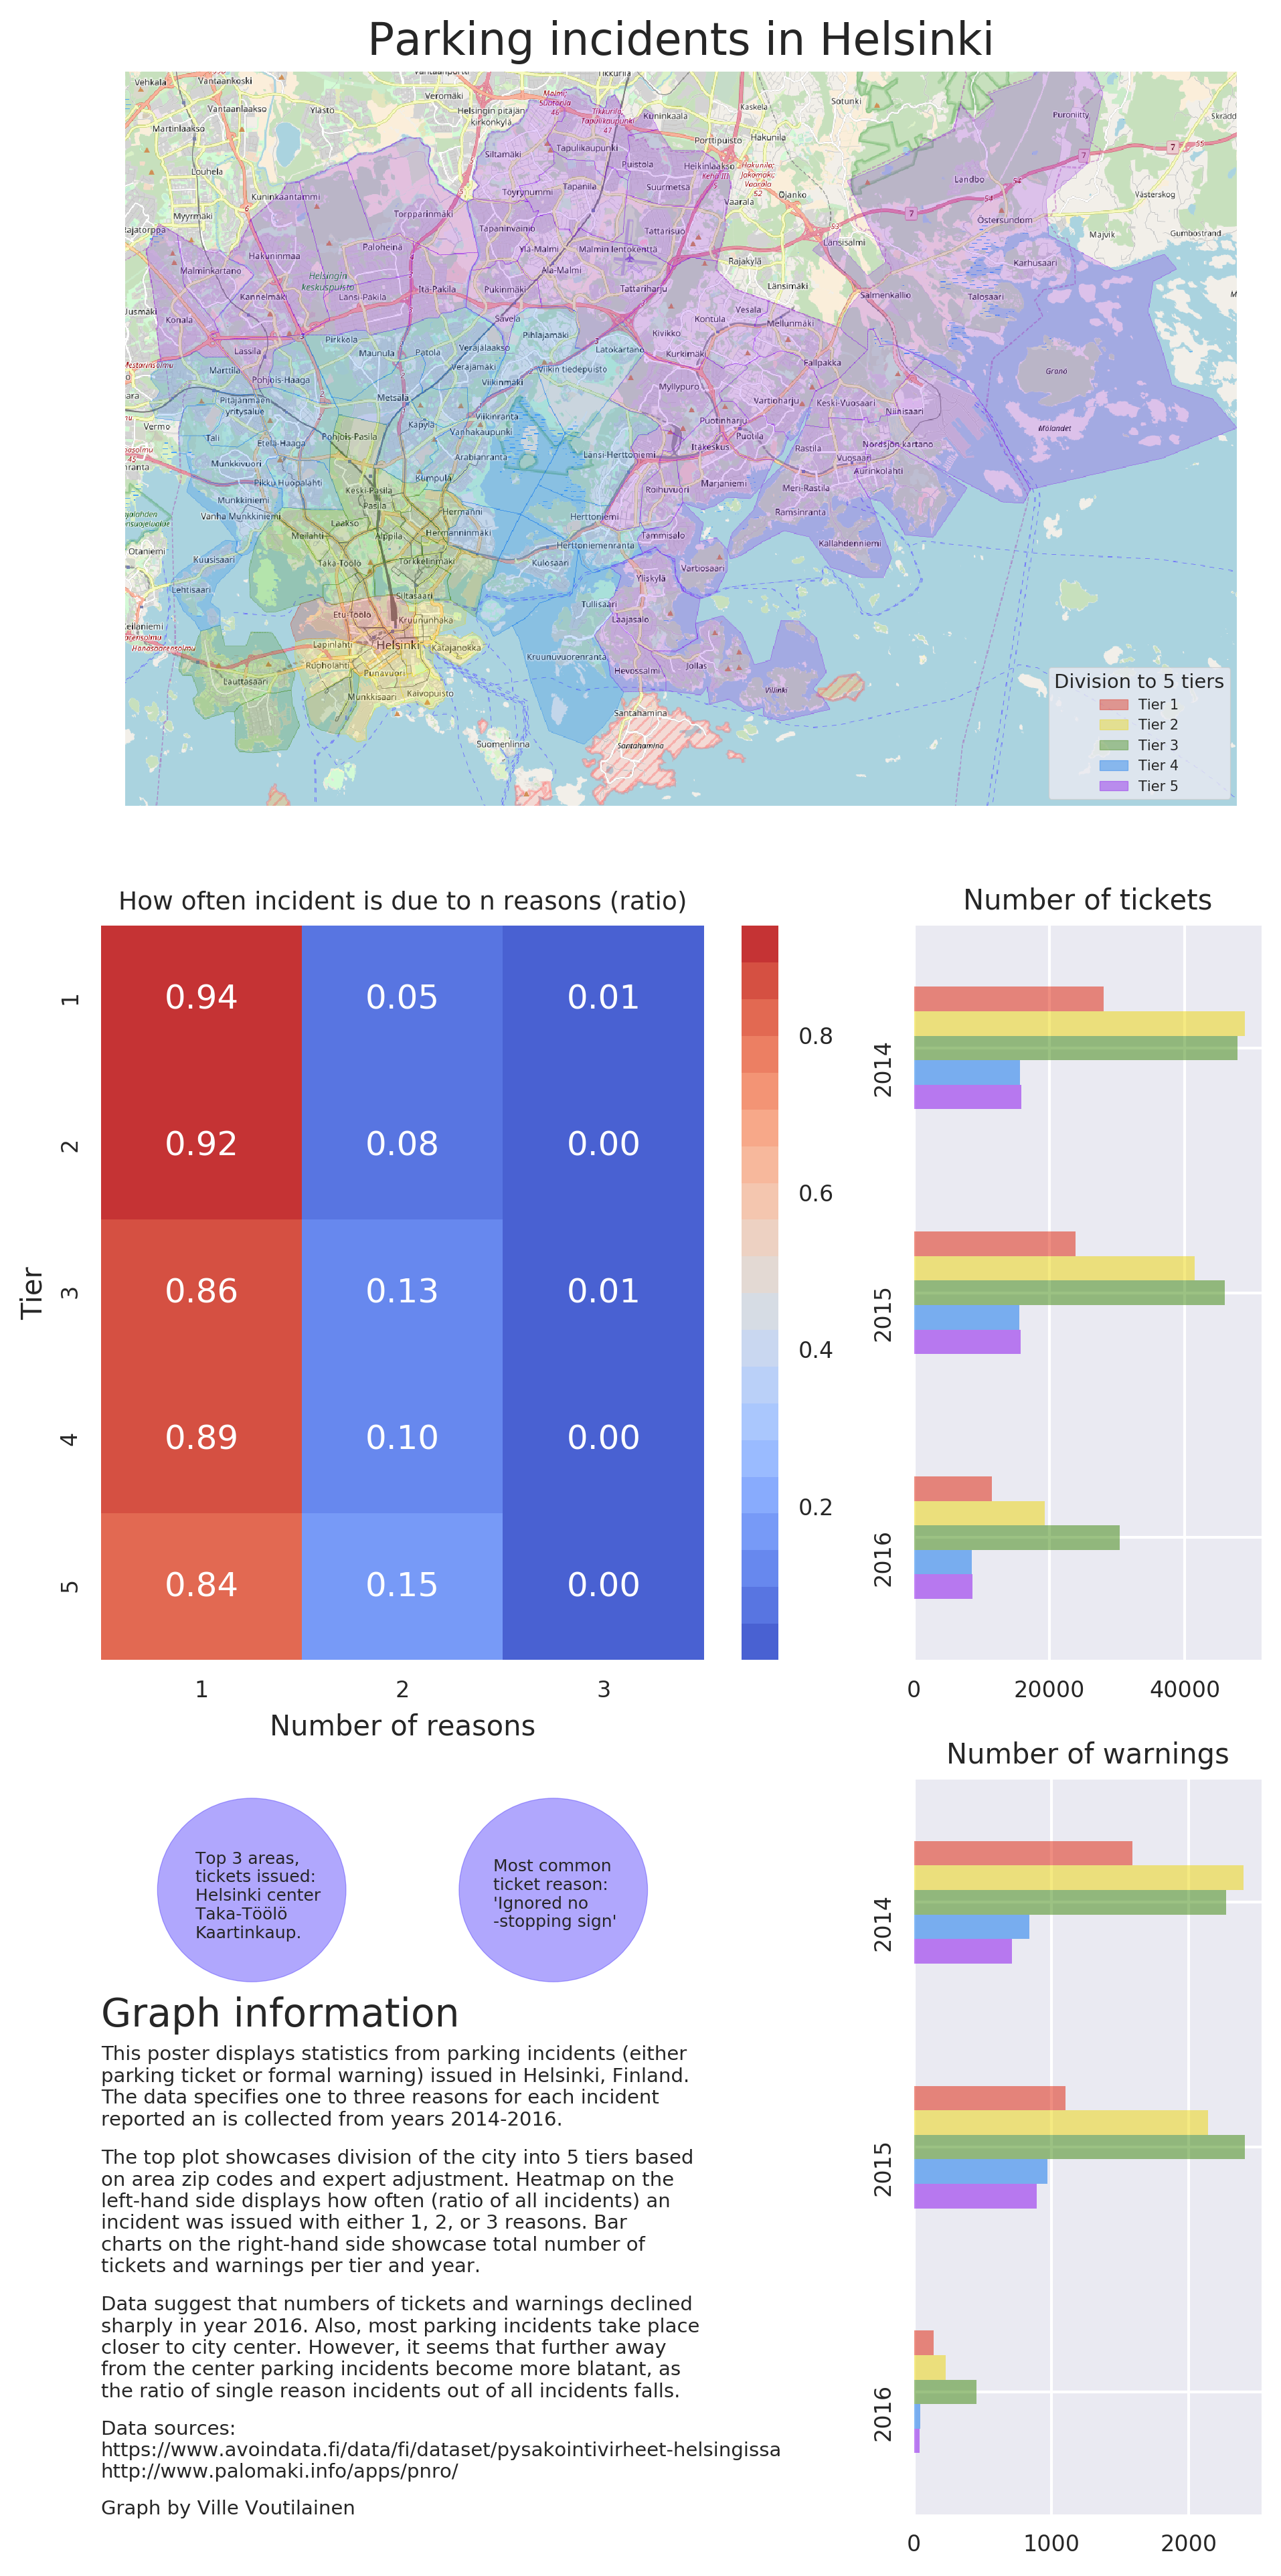

In [17]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
plt.close('all')
import matplotlib.image as image
sns.set_style("darkgrid")
mpl.rc("savefig", dpi=300)

# Image is 1427x943, 1423/943 = 1.513
im = image.imread('map.png')

fig = plt.figure()
height = 13
fig.set_size_inches(height/3 *1.513, height)

title_size = 10
plt.rcParams["axes.labelsize"] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

gs = mpl.gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1,0:2])
ax31 = plt.subplot(gs[1,2])
ax32 = plt.subplot(gs[2,2])
ax4 = plt.subplot(gs[2,0:2])

# Map on ax1 
ax1.imshow(im)
ax1.grid(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Parking incidents in Helsinki", fontsize = title_size + 6) 

# ax 1 legend with same colors as in the map plot above but 
# with reduced alpha
alpha = 0.4
map_colors_alpha = []
for i in range(5):
    map_colors_alpha.append(mcolors.to_rgb(map_colors[i]) + (alpha,))
handles = []
labels = []
labels = list(df['Tier'].sort_values().astype(str).unique())
labels = ['Tier ' + s for s in labels]
for i in range(5):
    handles.append(mpatches.Patch(color = map_colors_alpha[i]))
leg1 = ax1.legend(handles , labels, loc = 4, frameon = True, fontsize = 5) 
leg1.set_title("Division to 5 tiers", prop = {'size':'xx-small'})

# Heat map on ax 2
colors = sns.color_palette("coolwarm", 20)
cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors, len(colors))
heatmap = sns.heatmap(hm_data, cmap = cmap, annot = True, fmt = '0.2f', ax = ax2)
heatmap.set_title('How often incident is due to n reasons (ratio)', fontsize = title_size - 1)
heatmap.set(xlabel = 'Number of reasons')
colorbar = heatmap.collections[0].colorbar

# Axes 3
counter = 0
for typ in ['Ticket', 'Warning']:
    gg = df[['Tier', 'Type', 'Year']].reset_index().groupby(['Tier','Type','Year'], as_index = False).count().sort_values('Tier', ascending = True)
    gg = gg[gg['Type'] == typ]
    gg = gg[['Tier','Year','index']]
    gg = gg.pivot(index = 'Year',columns = 'Tier',values = 'index')
    gg.index.name = None
    gg = gg.iloc[:, ::-1]
    gg = gg.iloc[::-1]
    if typ == 'Ticket':
        gg.plot.barh(ax = ax31, color =map_colors[::-1], alpha = 0.5)
        ax31.set_title("Number of tickets", fontsize = title_size)
        ax = ax31
    elif typ == 'Warning':
        gg.plot.barh(ax = ax32, color = map_colors[::-1], alpha = 0.5)
        ax = ax32        
        ax32.set_title("Number of warnings", fontsize = title_size)        
    
    #ax.grid(False)
    for tick in ax.get_yticklabels():
        tick.set_rotation(90)
    #xlabels = ax1.set_xticklabels(['2016','250th','half','750th','last'], rotation = 5, fontsize = 'large')
    ax.legend_.remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    
    counter += 1

    
# Ax4 with text
ax4.grid(False)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.patch.set_alpha(0)

# Top 3 tickets, top reason! 
circ1 = plt.Circle((0.20, 0.85), 0.125, color = (59/255, 37/255, 252/255, 0.4))
ax4.add_artist(circ1)
string = 'Top 3 areas,\ntickets issued:\nHelsinki center\nTaka-Töölö\nKaartinkaup.'
ax4.text(0.125, 0.785, string, fontsize = 6, ha = 'left', wrap=True)

circ2 = plt.Circle((0.60, 0.85), 0.125, color = (59/255, 37/255, 252/255, 0.4))
ax4.add_artist(circ2)
string = "Most common\nticket reason:\n'Ignored no\n-stopping sign'"
ax4.text(0.52, 0.80, string, fontsize = 6, ha = 'left', wrap=True)


string = 'This poster displays statistics from parking incidents (either\n' \
         'parking ticket or formal warning) issued in Helsinki, Finland. \n' \
         'The data specifies one to three reasons for each incident\n' \
         'reported an is collected from years 2014-2016.'
            
string2 = 'The top plot showcases division of the city into 5 tiers based\n' \
          'on area zip codes and expert adjustment. Heatmap on the\n' \
          'left-hand side displays how often (ratio of all incidents) an\n' \
          'incident was issued with either 1, 2, or 3 reasons. Bar\n' \
            'charts on the right-hand side showcase total number of\n' \
            'tickets and warnings per tier and year.'

string3 = 'Data suggest that numbers of tickets and warnings declined\n' \
          'sharply in year 2016. Also, most parking incidents take place\n' \
          'closer to city center. However, it seems that further away\n' \
          'from the center parking incidents become more blatant, as\n'\
        'the ratio of single reason incidents out of all incidents falls.'            
            
string4 = 'Data sources:\nhttps://www.avoindata.fi/data/fi/dataset/pysakointivirheet-helsingissa\n'\
          'http://www.palomaki.info/apps/pnro/'\
        
string5 = 'Graph by Ville Voutilainen'        

para_text_size = 7
ax4.text(0.0, 0.665, 'Graph information', fontsize = 14, ha = 'left')                
ax4.text(0.0, 0.53, string, fontsize = para_text_size, ha = 'left')
ax4.text(0.0, 0.33, string2, fontsize = para_text_size, ha = 'left')
ax4.text(0.0, 0.16, string3, fontsize = para_text_size, ha = 'left')
ax4.text(0.0, 0.05, string4, fontsize = para_text_size, ha = 'left')
ax4.text(0.0, 0.00, string5, fontsize = para_text_size, ha = 'left')

fig.tight_layout()
gs.update(left = None, right = None, top = None, bottom = None, wspace = 0.17, hspace = None)

plt.savefig('Assignment4.png')
fig